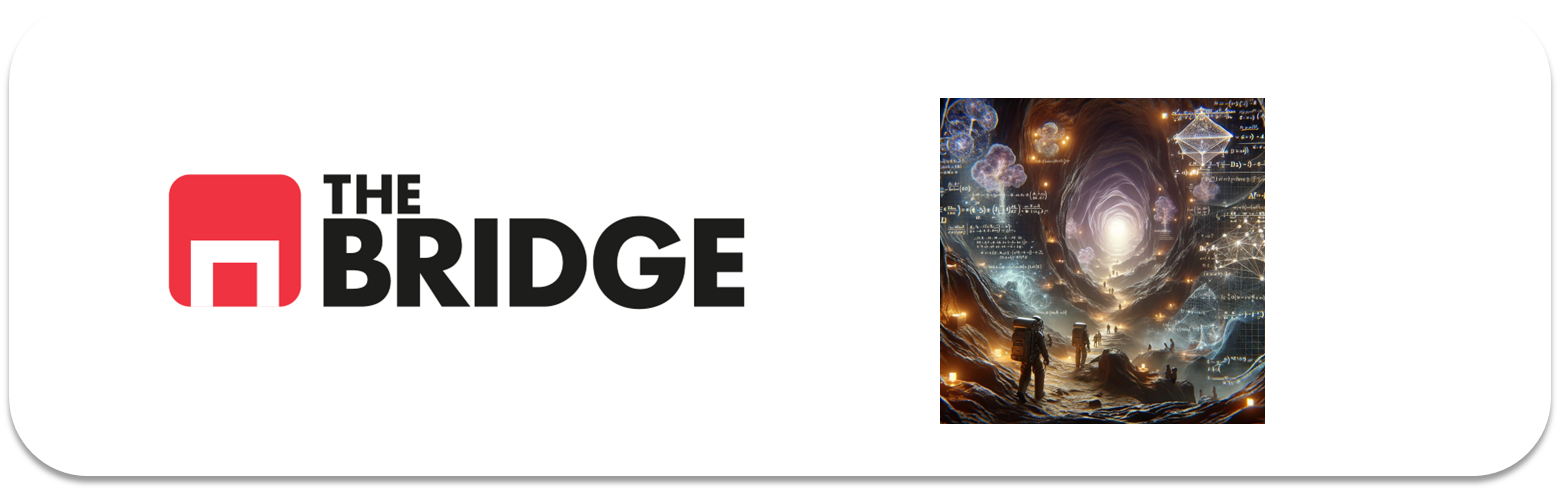

## PRACTICA OBLIGATORIA: **Introducción Deep Learning**

* La práctica obligatoria de esta unidad consiste en un único ejercicio de modelado del dataset del titanic empleando y comparando dos modelos diferentes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [36]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                             ConfusionMatrixDisplay, f1_score, precision_score, recall_score)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from utils import datascience as ds
from utils import vizdatatools as viz

### Descripción y objetivo

El objetivo de la práctica es crear un modelo DL y compararlo con un modelo Random Forest para el dataset de titanic, los dos con el mismo objetivo, predecir la supervivencia de un pasajero. Se pide:
  
1. Desarrollar el proceso de ML hasta crear los dos modelos DL y Random Forest. El primero debe tener una topología MLP (es decir una red densa) con un máximo de 3 capas ocultas y debes emplear sklearn para crearlo. No es necesario hacer una análisis/seleccion exahustivo. Escoge una métrica acorde al tipo de target del problema. 

2. Ambos modelos deben tener sus hiperparámetros optimizados, mediante GridSearch. Para ello: utiliza el grid de parámetros que creas conveniente para Random Forest y para el modelo DL, utiliza un grid con los hiperparámetros siguientes:'hidden_layer_sizes','activation', 'solver','alpha' y 'learning_rate'. Para los rangos del grid del modelo de DL guíate por lo visto en el workout y por los posibles valores que se indican en la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier). Prueba por lo menos una topología con una sola capa oculta y otra con más de una capa oculta.   
NOTA: Incluye los valores por defecto de los hiperparámetros escogidos en cada caso dentro del grid de hiperparámetros. 
  

3. Compara los modelos respecto a sus métricas medias de accuracy, precision, recall y tiempos de entrenamiento (para ello tendrás que realizar un entrenamiento a parte del mejor modelo obtenido en la optimización de hiperparámetros) y decide cuál te quedarías argumentándolo.    

4. Para el mejor modelo DL obtenido, muestra su clasification report, y la matriz de confusión comentando el resultado.


### Cargar dataset

In [37]:
df_titanic = pd.read_csv('./data/titanic.csv')
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [38]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


Es un dataframe que hay que limpiar un poco.

### Split de train y test y limpieza

Voy a hacer la limpieza del dataset con todo lo que ya se de este dataframe (porque lo venimos trabajando bastante en el bootcamp), y algunas cosas las haré directamente sobre el dataframe original, aunque antes habría que hacer el split de train y test.

In [39]:
# Eliminar columa redundantes
df_titanic.drop(columns=['deck', 'alive', 'class', 'embarked'], inplace=True)

# Calcular número de mienbros de la familia de cada pasajero
df_titanic["family_members"] = df_titanic.parch + df_titanic.sibsp
df_titanic = df_titanic.drop(['parch', 'sibsp', 'alone'], axis=1)

# Imputar los valores NaN de "embark_town" con la moda, aunque no es lo más correcto hacerlo aquí
df_titanic['embark_town'] = df_titanic['embark_town'].fillna(df_titanic['embark_town'].mode()[0])


In [40]:
# Split de train y test
train_set, test_set = train_test_split(df_titanic, test_size=0.2, stratify=df_titanic['survived'], random_state=42)

In [41]:
# Sustituir los valores faltantes de "age" por la mediana del train_set
is_man = train_set['who'] == 'man'
is_woman = train_set['who'] == 'woman'
is_child = train_set['who'] == 'child'

man_mean_age = round(train_set.loc[is_man, 'age'].median(), 1)
woman_mean_age = round(train_set.loc[is_woman, 'age'].median(), 1)
child_mean_age = round(train_set.loc[is_child, 'age'].median(), 1)

# Aplicar sobre train_set
train_set.loc[is_man, 'age'] = train_set.loc[is_man, 'age'].fillna(man_mean_age)
train_set.loc[is_woman, 'age'] = train_set.loc[is_woman, 'age'].fillna(woman_mean_age)
train_set.loc[is_child, 'age'] = train_set.loc[is_child, 'age'].fillna(child_mean_age)

# Aplicar sobre test_set
df_titanic['embark_town'] = df_titanic['embark_town'].fillna(df_titanic['embark_town'].mode()[0])
test_set

test_set.loc[test_set['who'] == 'man', 'age'] = test_set.loc[test_set['who'] == 'man', 'age'].fillna(man_mean_age)
test_set.loc[test_set['who'] == 'woman', 'age'] = test_set.loc[test_set['who'] == 'woman', 'age'].fillna(woman_mean_age)
test_set.loc[test_set['who'] == 'child', 'age'] = test_set.loc[test_set['who'] == 'child', 'age'].fillna(child_mean_age)

# Eliminar "who" y "adult_male" porque ahora son redundantes
train_set.drop(columns=['who', 'adult_male'], inplace=True)
test_set.drop(columns=['who', 'adult_male'], inplace=True)

### Mini-EDA

In [42]:
print(train_set['survived'].value_counts())
print(train_set['survived'].value_counts(True))


survived
0    439
1    273
Name: count, dtype: int64
survived
0    0.616573
1    0.383427
Name: proportion, dtype: float64


In [43]:
train_set.describe(include='all')

,survived,pclass,sex,age,fare,embark_town,family_members
count,712.000000,712.000000,712,712.000000,712.000000,712,712.000000
unique,NaN,NaN,2,NaN,NaN,3,NaN
top,NaN,NaN,male,NaN,NaN,Southampton,NaN
freq,NaN,NaN,459,NaN,NaN,518,NaN
mean,0.383427,2.308989,NaN,29.844691,31.819826,NaN,0.883427
std,0.486563,0.833563,NaN,13.015275,48.059104,NaN,1.589047
min,0.000000,1.000000,NaN,0.420000,0.000000,NaN,0.000000
25%,0.000000,2.000000,NaN,22.000000,7.895800,NaN,0.000000
50%,0.000000,3.000000,NaN,30.000000,14.454200,NaN,0.000000
75%,1.000000,3.000000,NaN,36.000000,31.000000,NaN,1.000000


Es un dataset algo desbalanceado. Intentaré usar una "class_weight" para compensarlo.

Voy a definir el *target*, las features numéricas y las categóricas.

In [44]:
ds.get_cardinality(train_set)

pandas.DataFrame shape:  (712, 7)


,Card,%_Card,NaN_Values,%_NaN_Values,Type,Class
survived,2,0.280899,0,0.0,int64,Binary
pclass,3,0.421348,0,0.0,int64,Categoric
sex,2,0.280899,0,0.0,object,Binary
age,85,11.938202,0,0.0,float64,Numeric - Discrete
fare,226,31.741573,0,0.0,float64,Numeric - Continuous
embark_town,3,0.421348,0,0.0,object,Categoric
family_members,9,1.264045,0,0.0,int64,Categoric


In [45]:
target = 'survived'
num_features = ['age', 'fare']
cat_features = ['pclass', 'sex', 'embark_town', 'family_members']

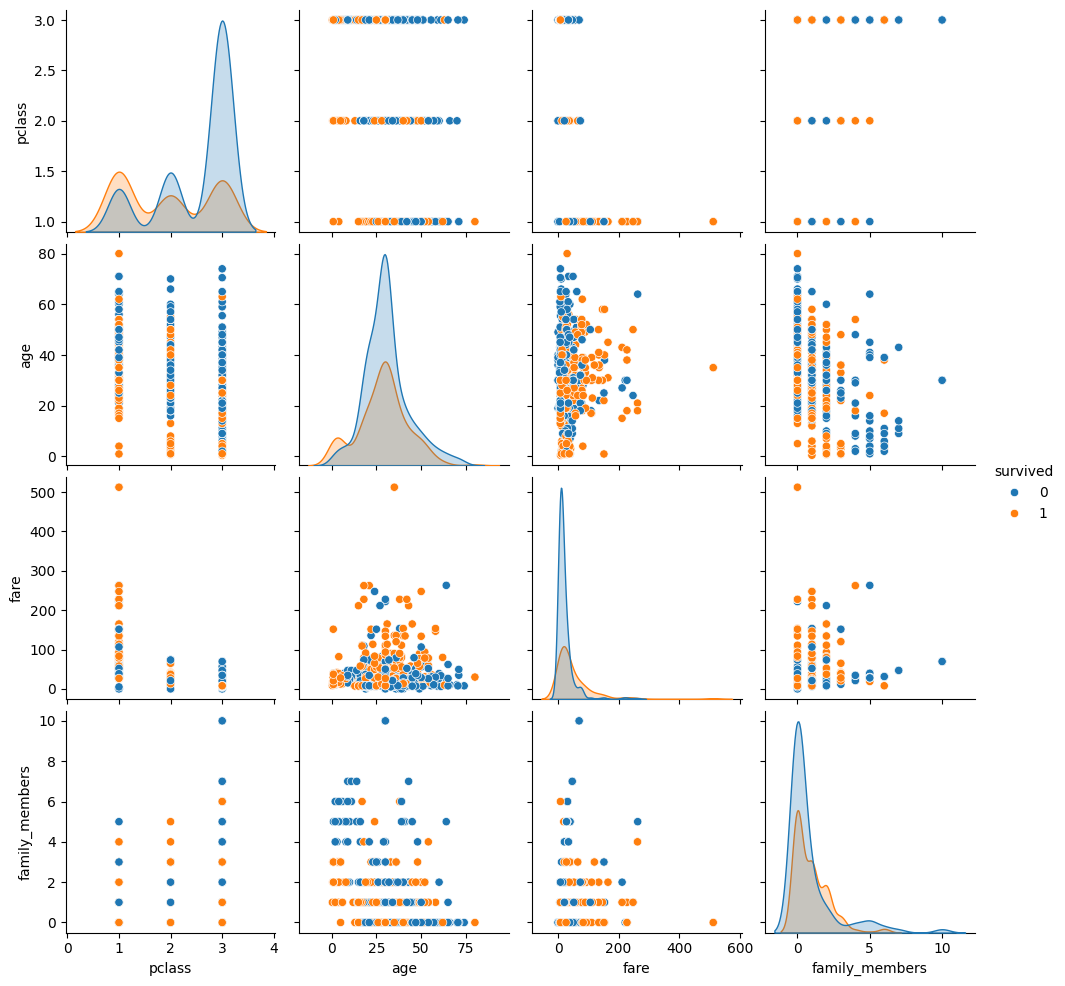

In [46]:
sns.pairplot(train_set, hue=target);

Con este análisis visual encuentro unas distribuciones muy interesantes y todas las variables numéricas me parecen interesantes y estar relacionadas con el target.

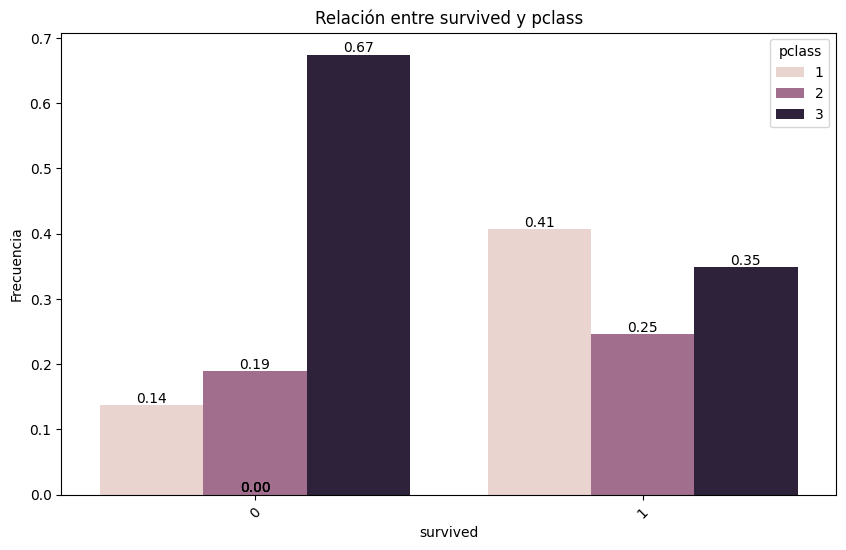

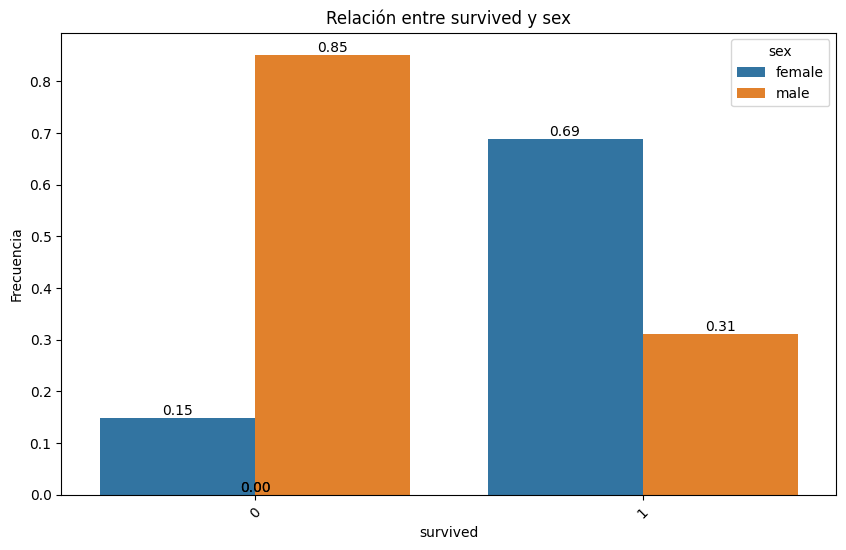

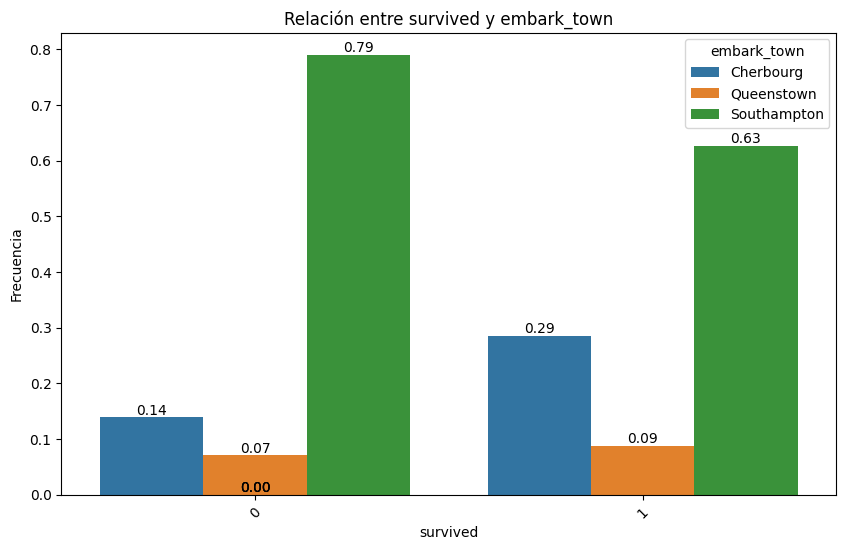

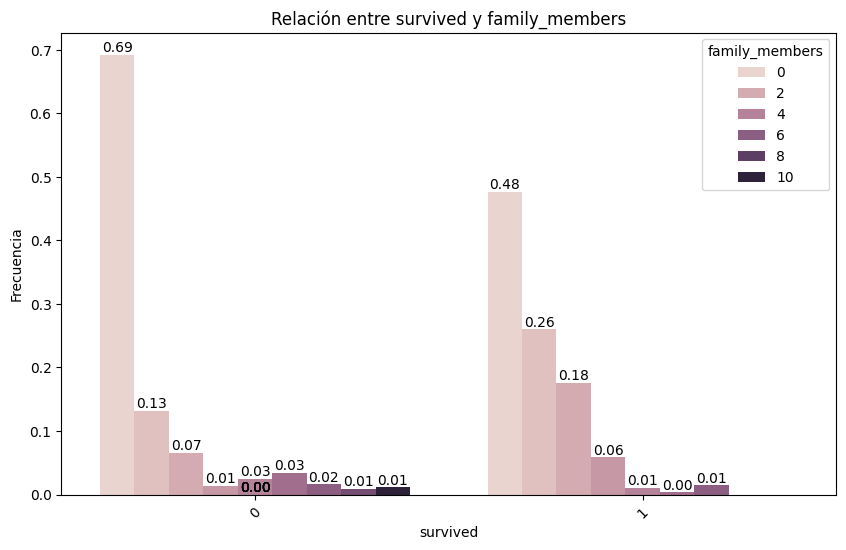

In [47]:
for feat in cat_features:
    viz.plot_categorical_relationship(train_set, target, feat, show_values=True, relative_freq=True)

Respecto a las variables categóricas todas paracen discernir bien entre los casos de supervivencia o no, así que también conservo todas.


Podría profundizar más en la elección de features pero es que son ya de por sí pocas, además de que he realizado una limpieza de features. Para que tenga sentido el modelo de DL no quiero reducir más el número de features.

### Preparar features

Para los modelos de DL es importante que los datos estén escalados.

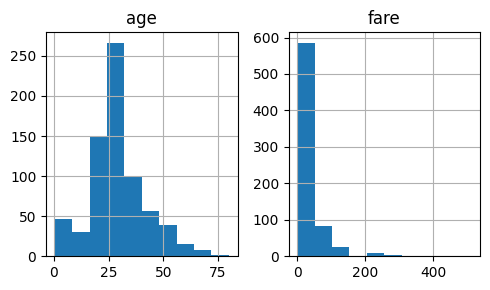

In [48]:
train_set[num_features].hist(figsize=(5, 3));
plt.tight_layout()


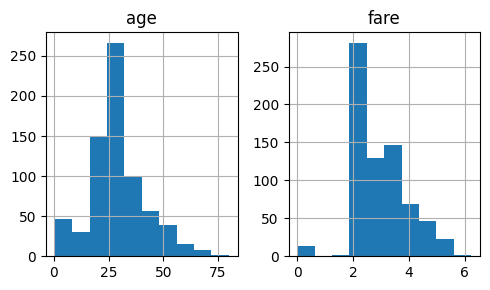

In [49]:
# Aplicar logaritmo a "fare" para que tenga una distribución más normal
train_set['fare'] = np.log1p(train_set['fare'])
test_set['fare'] = np.log1p(test_set['fare'])

# Ver la nueva distribución
train_set[num_features].hist(figsize=(5, 3));
plt.tight_layout()

Sobre las variables **categóricas**:
- Sobre 'pclass' y 'family_members' voy a hacer un OrdinalEncoder, básicamente tienen ya hecho un OrdinalEncoder, así que no voy a hacer nada sobre ellas.
- Sobre "sex" y "embark_town" voy a hacer un One-Hot encoding elimando una de las categorías para evitar la colinealidad.

In [50]:
train_set['pclass'].value_counts()

pclass
3    391
1    171
2    150
Name: count, dtype: int64

In [51]:
train_set['family_members'].value_counts()

family_members
0     434
1     129
2      77
3      22
5      16
4      14
6      11
10      5
7       4
Name: count, dtype: int64

In [52]:
# One-Hot Encoder sobre las categóricas de baja cardinalidad
train_set = pd.get_dummies(train_set, columns=['sex', 'embark_town'], dtype=int, drop_first=True)
test_set = pd.get_dummies(test_set, columns=['sex', 'embark_town'], dtype=int, drop_first=True)

# Estandad scaler sobre las features con otros ordenes de magnitud
scaler = StandardScaler()
train_set[['age', 'fare']] = scaler.fit_transform(train_set[['age', 'fare']])
test_set[['age', 'fare']] = scaler.transform(test_set[['age', 'fare']])

In [53]:
# Ver distribución del set de train
train_set.describe()

,survived,pclass,age,fare,family_members,sex_male,embark_town_Queenstown,embark_town_Southampton
count,712.000000,712.000000,7.120000e+02,7.120000e+02,712.000000,712.000000,712.000000,712.000000
mean,0.383427,2.308989,2.444986e-16,2.432511e-16,0.883427,0.644663,0.077247,0.727528
std,0.486563,0.833563,1.000703e+00,1.000703e+00,1.589047,0.478952,0.267171,0.445544
min,0.000000,1.000000,-2.262371e+00,-3.014278e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,-6.031533e-01,-7.816835e-01,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,1.194121e-02,-2.175011e-01,0.000000,1.000000,0.000000,1.000000
75%,1.000000,3.000000,4.732621e-01,5.260112e-01,1.000000,1.000000,0.000000,1.000000
max,1.000000,3.000000,3.856282e+00,3.360891e+00,10.000000,1.000000,1.000000,1.000000


In [54]:
# Ver distribución del set de test
# test_set.describe()

### Split de X e y

In [55]:
# Split de X e y
X_train = train_set.drop(columns=[target])
y_train = train_set[target]

X_test = test_set.drop(columns=[target])
y_test = test_set[target]


### Ajuste de hiperaparámetros en los dos modelos

Aunque el set no está balanceado entre supervivientes y no supervivientes... considero que tenga que darle una prioridad mayor a ninguno de los dos, así que voy a usar como métrica de optimización para ajuste de mis hiperparámetros el F1-Score

In [56]:
# Parámetros comunes para GridSearchCV
kwargs = {
    'scoring': 'f1', 
    'cv': 5, 
    'verbose': 1,
    'n_jobs': -2
}

### Modelo RandomForest

In [57]:
# RandomForestClassifier

param_grid = {'n_estimators': [100, 200, 300],
               'max_depth': [10, 20, 30, None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]
               }

rf_grid = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                       param_grid=param_grid,
                       **kwargs
                       )

# Obtener mejores hiperparámetros
start = time.time()
rf_grid.fit(X_train, y_train)
end = time.time()
grid_search_train_time = end - start

print(f'Mejores parámetros: {rf_grid.best_params_}')
print(f'Mejor F1-Score: {rf_grid.best_score_}')

# ¡WARNING! Este paso NO es neceserio
# Vuelvo a entrenar el mejor modelo solo para ver cuánto tardaría
start = time.time()
rf_grid = rf_grid.best_estimator_
rf_grid.fit(X_train, y_train)
end = time.time()
train_time = end - start

# Predicciones
start = time.time()
y_pred = rf_grid.predict(X_test)
end = time.time()
pred_time = end - start

# Guardamos las métricas de evaluación en un dataframe
rf_metrics = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                           'precision': precision_score(y_test, y_pred, average='binary'),
                           'recall': recall_score(y_test, y_pred, average='binary'),
                           'f1': f1_score(y_test, y_pred, average='binary'),
                           'grid_search_train_time': grid_search_train_time,
                           'train_time': train_time,
                           'pred_time': pred_time
                           },
                          index=['RandomForestClassifier']
                          )                       
rf_metrics

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Mejores parámetros: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Mejor F1-Score: 0.757591132016868


,accuracy,precision,recall,f1,grid_search_train_time,train_time,pred_time
RandomForestClassifier,0.804469,0.803571,0.652174,0.72,33.44469,0.242046,0.008004


### Modelo MLP (Multilayer Perceptron)

In [58]:
# MLP

# No tengo mucha idea de los criterios que estoy eligiendo para las layers
param_grid = {'max_iter': [100, 200],
              'hidden_layer_sizes': [(100,), 
                                     (50, 50), 
                                     (100, 100),
                                     (100, 50, 50)],
              'activation': ['tanh', 'relu'],
              'solver': ['adam', 'sgd'],
              'alpha': [0.001, 0.001],
              'learning_rate': ['constant', 'adaptive']
              }

mlp_grid = GridSearchCV(estimator=MLPClassifier(max_iter=200, random_state=42),
                        param_grid=param_grid,
                        **kwargs
                        )

# Obtener mejores hiperparámetros
start = time.time()
mlp_grid.fit(X_train, y_train)
end = time.time()
grid_search_train_time = end - start

print(f'Mejores parámetros: {mlp_grid.best_params_}')
print(f'Mejor F1-Score: {mlp_grid.best_score_}')

# ¡WARNING! Este paso NO es neceserio
# Vuelvo a entrenar el mejor modelo solo para ver cuánto tardaría
start = time.time()
mlp_grid = mlp_grid.best_estimator_
mlp_grid.fit(X_train, y_train)
end = time.time()
train_time = end - start

# Predicciones
start = time.time()
y_pred = mlp_grid.predict(X_test)
end = time.time()
pred_time = end - start

# Guardamos las métricas de evaluación en un dataframe
mlp_metrics = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                            'precision': precision_score(y_test, y_pred, average='binary'),
                            'recall': recall_score(y_test, y_pred, average='binary'),
                            'f1': f1_score(y_test, y_pred, average='binary'),
                            'grid_search_train_time': grid_search_train_time,
                            'train_time': train_time,
                            'pred_time': pred_time
                            },
                           index=['MLPClassifier']
                           )                       
mlp_metrics


Fitting 5 folds for each of 128 candidates, totalling 640 fits


c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mejores parámetros: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Mejor F1-Score: 0.7406244282911995


c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,accuracy,precision,recall,f1,grid_search_train_time,train_time,pred_time
MLPClassifier,0.787709,0.762712,0.652174,0.703125,33.054209,0.990851,0.002049


In [59]:
# Classification Report para el modelo MLPClassifier
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       110
           1       0.76      0.65      0.70        69

    accuracy                           0.79       179
   macro avg       0.78      0.76      0.77       179
weighted avg       0.79      0.79      0.78       179



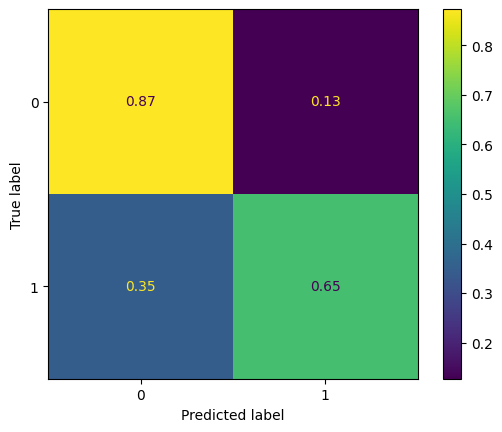

In [60]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')

- Clase 0: El MLPClassifier predice muy bien los no sobrevivientes, con una alta tasa de acierto (precisión) y capacidad de detectar la mayoría de los no sobrevivientes (recall).

- Clase 1:  MLP muestra algo de debilidad. Aunque la precisión sigue siendo aceptable (0.76), el recall es bajo (0.65), lo que significa que no está detectando muchos de los pasajeros que sobrevivieron.

Comparamos a continuación los resultados de ambos modelos.

In [61]:
# Comparamos los resultados de ambos modelos
metrics = pd.concat([rf_metrics, mlp_metrics])
metrics

,accuracy,precision,recall,f1,grid_search_train_time,train_time,pred_time
RandomForestClassifier,0.804469,0.803571,0.652174,0.720000,33.444690,0.242046,0.008004
MLPClassifier,0.787709,0.762712,0.652174,0.703125,33.054209,0.990851,0.002049


In [62]:
# Tiempo de entrenamiento
metrics.loc['MLPClassifier', 'train_time'] / metrics.loc['RandomForestClassifier', 'train_time']

4.093645188457617

In [64]:
# Tiempo de predicción
metrics.loc['RandomForestClassifier', 'pred_time'] / metrics.loc['MLPClassifier', 'pred_time']

3.906562718175471

### Conclusiones

#### Métricas

- Ambos modelos muestran una *accuracy* muy cercana, con una ligera ventaja para el RandomForestClassifier.
- El RandomForestClassifier tiene un mejor *precision*, lo que significa que cuando predice que un pasajero sobrevivirá, tiene mayor probabilidad de acertar en comparación con el MLP. (minimiza los FP)
- Ambos modelos tienen el mismo *recall*. Esto significa que ambos modelos tienen la misma capacidad de detectar correctamente a los pasajeros que sobreviven. (minimizan los FN).
- El f1-score también favorece al RandomForestClassifier, lo que sugiere un mejor balance entre precisión y recall. En mi opinión y en tanto que no hay otra indicación esta es la métrica que más me interesa en este caso del Titanic.

#### Tiempos de Entrenamiento y Predicción:

- Grid Search Training Time: Ambos modelos han requerido un tiempo muy similar para la búsqueda de hiperparámetros (pero esto depende del grid escogido).
- Train Time: El entrenamiento del RandomForestClassifier fue significativamente más rápido en comparación con el MLPClassifier. Fue 4 veces más rápido.
- Prediction Time: El MLPClassifier es casi 4 veces más rápido en el tiempo de predicción.

El RandomForestClassifier sigue siendo más eficiente en cuanto a tiempo de entrenamiento, lo que puede ser relevante si los recursos computacionales o el tiempo de entrenamiento son factores críticos.

#### Elección de modelo

- Dado que el RandomForestClassifier tiene un rendimiento ligeramente mejor en términos de precisión y f1-score, y su tiempo de entrenamiento es considerablemente más corto, me quedaría con el RandomForestClassifier. Es más eficiente en términos computacionales y ofrece un rendimiento global más equilibrado, sin sacrificar mucho en la capacidad de detectar supervivientes.